In [519]:
# Basic libraries
import pandas as pd 
import numpy as np
import re
from scipy import stats

# Visualisation libraries

import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap 
import seaborn as sns


# Modelling libraries
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from matplotlib_venn import venn2_unweighted

# Set styles and display options
pd.options.display.precision = 4

In [520]:
# # Check versions of packages etc
# import scipy
# import matplotlib
# import imblearn
# import seaborn
# import sklearn
# import xgboost

# print("Python: ")
# ! python --version
# print("Jupyter Notebooks: ")
# ! jupyter notebook --version
# print("\nScipy: ", scipy.__version__)
# print("Matplotlib: ", matplotlib.__version__)
# print("Imblearn: ", imblearn.__version__)
# print("Seaborn: ", seaborn.__version__)
# print("SKLearn: ", sklearn.__version__)
# print("XGBoost: ", xgboost.__version__)

In [521]:
# Functions
def farenheit_to_celsius(farenheit):
  return ((farenheit - 32) * (5/9))

def m_to_km(m):
  return (m*1.609344)

def in_to_mm(i):
  return (i*25.4)

# Function to retrieve performance metrics
def scores(name, y_test, y_pred):
        list = [name,
                precision_score(y_test, y_pred, average='weighted'),
                recall_score(y_test, y_pred, average='weighted'),
                f1_score(y_test, y_pred, average='weighted'),
                accuracy_score(y_test, y_pred)]
        return list

In [522]:
# Load data
# df = pd.read_csv('ny_accidents.csv')

# Import data for Google Collab. Remove before submission
url = 'https://raw.githubusercontent.com/aqualytics/INFT6201-Assignment3/main/ny_accidents.csv?token=GHSAT0AAAAAABZNNFLGDHXVZMJZZRLCVUMQYZXUG3Q'
df = pd.read_csv(url)

# Drop columns that won't be used in the analysis
try: # remove exception handling before submission
  cols = ['Unnamed: 0','Number', 'Airport_Code', 'Timezone', 'Country', 'State', 'Civil_Twilight','Nautical_Twilight','Astronomical_Twilight','Turning_Loop']
  df.drop(cols, axis=1, inplace=True)
except:
  pass

# Drop duplicates
df.drop_duplicates()

# Drop rows with na values
df.dropna(inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36779 entries, 0 to 39536
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 36779 non-null  object 
 1   Severity           36779 non-null  int64  
 2   Start_Time         36779 non-null  object 
 3   End_Time           36779 non-null  object 
 4   Start_Lat          36779 non-null  float64
 5   Start_Lng          36779 non-null  float64
 6   End_Lat            36779 non-null  float64
 7   End_Lng            36779 non-null  float64
 8   Distance.mi.       36779 non-null  float64
 9   Description        36779 non-null  object 
 10  Street             36779 non-null  object 
 11  Side               36779 non-null  object 
 12  City               36779 non-null  object 
 13  County             36779 non-null  object 
 14  Zipcode            36779 non-null  object 
 15  Weather_Timestamp  36779 non-null  object 
 16  Temperature.F.     367

In [523]:
# Pre-process of data
# Rename columns 
df.rename(columns = {'Distance.mi.':'Distance',
                     'Wind_Speed.mph.':'Wind_Speed',
                     'Temperature.F.':'Temperature',
                     'Wind_Chill.F.':'Wind_Chill',
                     'Humidity...':'Humidity',
                     'Pressure.in.':'Pressure',
                     'Visibility.mi.':'Visibility',
                     'Precipitation.in.':'Precipitation'}, inplace=True)

## Variable groups as lists
weather = ['Weather_Timestamp', 'Temperature', 'Wind_Chill', 'Humidity', 'Pressure','Visibility','Wind_Direction','Wind_Speed','Precipitation','Weather_Condition']
poi = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']
poi1 = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal', 'Any_poi']

# Convert dates & times to datetime type
cols = ['Start_Time','End_Time','Weather_Timestamp']
df[cols] = df[cols].apply(pd.to_datetime, errors='coerce')

# Convert imperial units to metric
df[['Temperature', 'Wind_Chill']] = df[['Temperature', 'Wind_Chill']].apply(farenheit_to_celsius) # farenheit to celsius
df[['Visibility', 'Wind_Speed']] = df[['Visibility', 'Wind_Speed']].apply(m_to_km) # miles to kilometres
df['Precipitation'] = df['Precipitation'].apply(in_to_mm) # inches to mm

# Add severity_cat column
conditions  = [ df['Severity'] == 1, df['Severity'] == 2, df['Severity'] == 3, df['Severity'] == 4 ]
choices     = [ 'Low','Medium','High','Very High']
df['severitycat'] = np.select(conditions, choices, default=np.nan)

# Add highway column
keywords = ['Pkwy', 'Parkway', 'I-', 'Interstate', 'Expy', 'Exp', 'Expressway', 'Route', 'State', 'NY', 'Trwy', 'Throughway', 'US', 'Hwy', 'Highway', 'Wyck', '9n']
df['Highway'] = False #where False = other
df.loc[df['Street'].str.contains('|'.join(keywords), case = False) == True, 'Highway'] = True #where True = Highway

# Add weather_cat column to consolidate weather conditions
conditions = [df['Weather_Condition'].str.contains('Clear|Fair', case=False) == True,
              df['Weather_Condition'].str.contains('Cloud|Overcast', case=False) == True,
              df['Weather_Condition'].str.contains('Rain|Storm', case=False) == True,
              df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False) == True,
              df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False) == True,
              df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', flags=re.IGNORECASE, regex=True) == True,
              df['Weather_Condition'].str.contains('Fog', case=False) == True]
choices = ['Clear', 'Cloud', 'Rain', 'Heavy_rain', 'Snow', 'Heavy_Snow','Fog']
df['Weather_Condition'] = np.select(conditions, choices, default='Other') # Assign null value as clear

# Clean wind direction
df['Wind_Direction'].replace({'North':'N','West':'W','East':'E','Variable':'VAR','South':'S'}, inplace=True)


# Add season category
df['month'] = df['Start_Time'].dt.month
conditions = (df.month < 3, df.month < 5, df.month < 8, df.month <12, df.month == 12)
choices = ['winter', 'spring','summer', 'fall', 'winter']
df['season'] = np.select(conditions, choices, default=np.nan)
df.drop('month', axis=1, inplace=True)

# Add weekday
df['weekday'] = df['Start_Time'].dt.dayofweek

# Add month
df['month'] = df['Start_Time'].dt.month

# Add year
df['year'] = df['Start_Time'].dt.year

# Add incident duration
df['duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds().div(60).astype(int)

## Add Traffic_Calming_ex_Bump
df['Traffic_Calming_ex_Bump'] = df['Traffic_Calming']
df['Traffic_Calming_ex_Bump'] = np.where(df.Bump == True, False, df['Traffic_Calming_ex_Bump'])

## Add Any_poi (collapsed poi)
df['Any_poi'] = (df.Amenity + df.Bump + df.Crossing + df.Give_Way + df.Junction + df.No_Exit + df.Railway + df.Roundabout + df.Station + df.Stop + df.Traffic_Calming + df.Traffic_Signal)

          count  percent
Severity                
1           693     1.88
2         28664    77.94
3          4468    12.15
4          2954     8.03


<AxesSubplot:xlabel='Severity', ylabel='Ratio'>

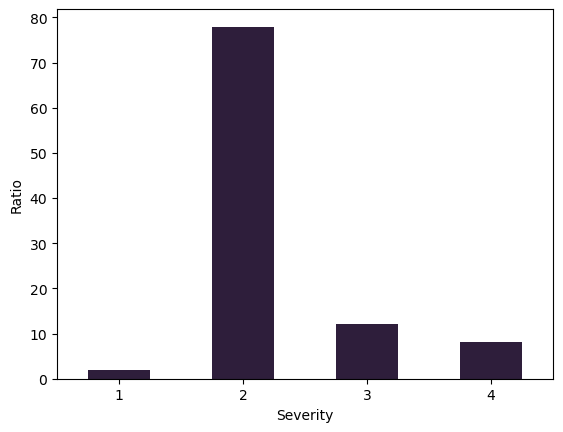

In [524]:
# Summarise Severity category
severity_prop = pd.DataFrame()
severity_prop['count'] = df['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
print(severity_prop)

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))

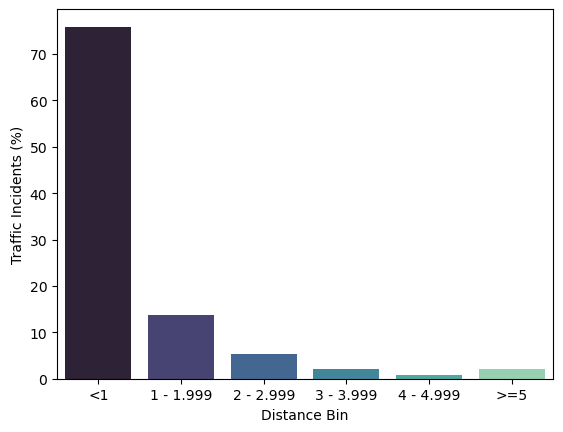

In [525]:
# Summarise Distance category
distance_prop = pd.cut(df['Distance'],
             bins=[0, 1, 2, 3, 4, 5, np.inf],
             labels=['<1','1 - 1.999','2 - 2.999', '3 - 3.999', '4 - 4.999', '>=5']).reset_index().groupby('Distance').count()
distance_prop = pd.DataFrame(distance_prop.reset_index().values)
distance_prop.set_axis(['distance_bin','count'], axis=1, inplace=True)
distance_prop['percent'] = distance_prop['count'].apply(lambda x: x / distance_prop['count'].sum() * 100)

# Distance counts by bin
ax = sns.barplot(x='distance_bin', y='percent', data=distance_prop, palette = 'mako')
ax.set(title='', xlabel="Distance Bin", ylabel="Traffic Incidents (%)")
plt.show()

          count  percent
Severity                
1           693     1.88
2         28664    77.94
3          4468    12.15
4          2954     8.03


<AxesSubplot:xlabel='Severity', ylabel='Ratio'>

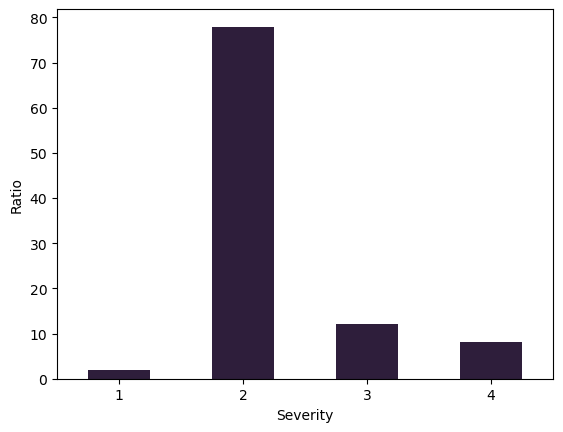

In [526]:
severity_prop['count'] = df['Distance'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
print(severity_prop)

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))

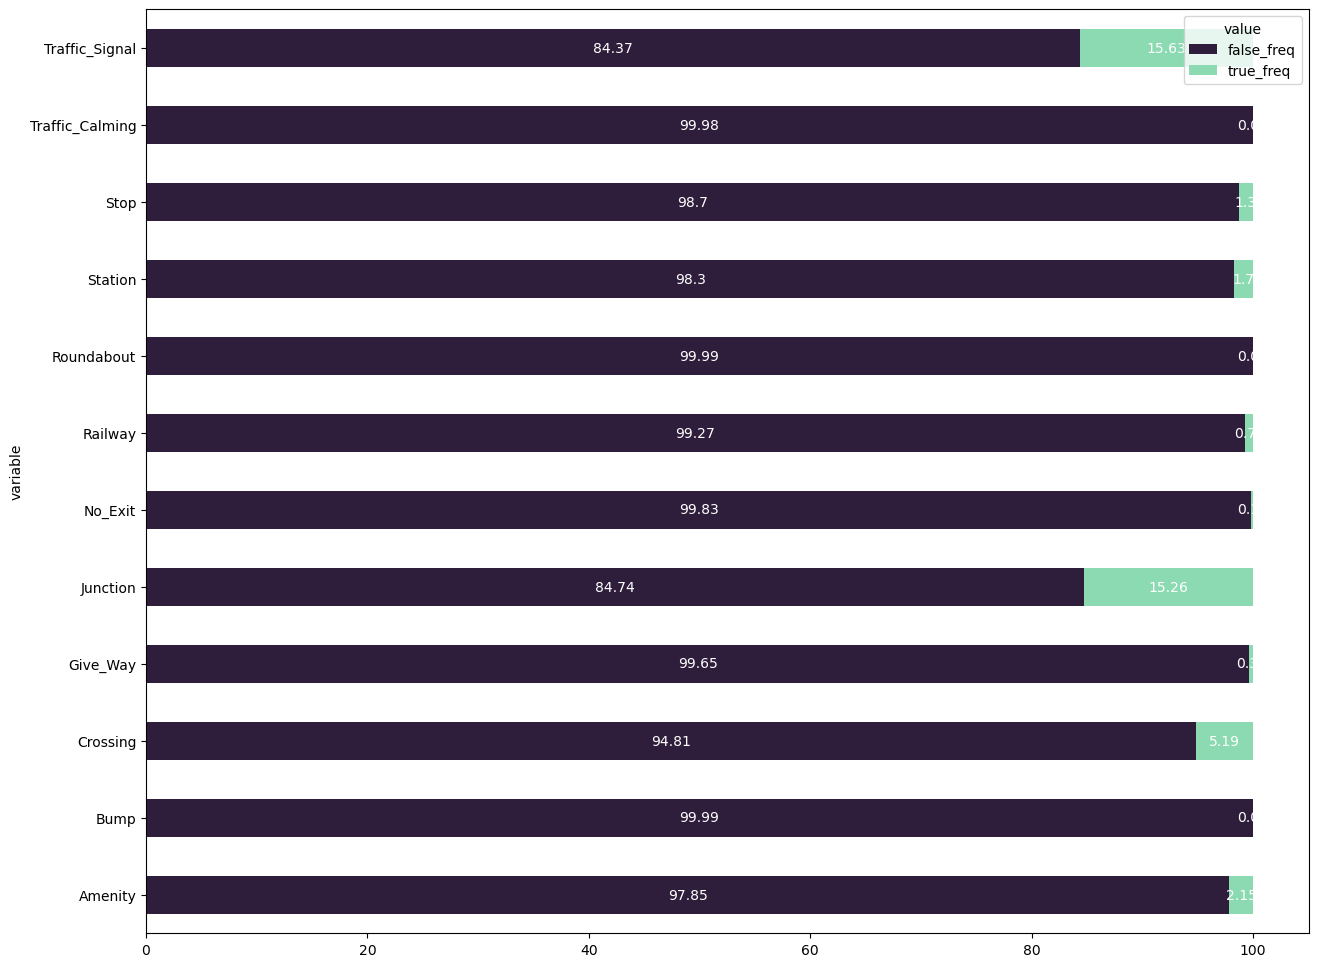

In [527]:
# Plot POI
poi_counts = df[poi].melt()
poi_counts = pd.crosstab(index=poi_counts['variable'], columns=poi_counts['value'])
poi_counts['false_freq'] = round((poi_counts[0] / (poi_counts[0] + poi_counts[1]))*100,2)
poi_counts['true_freq'] = round((poi_counts[1] / (poi_counts[0] + poi_counts[1]))*100,2)
poi_counts = poi_counts[['false_freq','true_freq']].copy()
labels = list(poi_counts.index.values)
ax = poi_counts.plot.barh(stacked=True, cmap=ListedColormap(sns.color_palette('mako')), figsize=(15, 12))
for c in ax.containers:
    ax.bar_label(c, label_type='center', color='#fff')

plt.show()

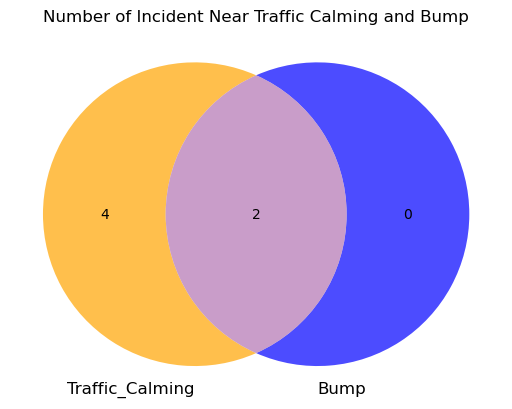

Mean of Severity for each Subset:


count  mean
Traffic_Calming Bump              
True            False      4  2.00
                True       2  4.00

Mean of Severity for all observations: 2.26


In [528]:
## poi: Traffic_Calming vs Bump (justification to create Variable Traffic_Calming_ex_Bump)

## Venn Diagram: Traffic_Calming & Bump
TC = df['Traffic_Calming'].sum()
B =  df['Bump'].sum()

df['total_TC_B'] = df['Traffic_Calming'].astype(int) + df['Bump'].astype(int)
df['TC_and_B'] = pd.Series(df.total_TC_B == 2).map({True: 1, False: 0})
TC_B = TC_B = df['TC_and_B'].sum()

## Depict diagram
venn2_unweighted(subsets = (TC-TC_B, B-TC_B, TC_B),
                 set_labels = ('Traffic_Calming','Bump'),
                 set_colors=("orange","blue"),alpha=0.7)

plt.title('Number of Incident Near Traffic Calming and Bump')
plt.show()

## Show Mean of Severity
print("Mean of Severity for each Subset:")
display(df[(df.total_TC_B > 0)].groupby(['Traffic_Calming','Bump'])['Severity'].agg(['count','mean']))
print(("Mean of Severity for all observations: {:.2f}").format(df['Severity'].mean()))

In [529]:
## Summarise poi data
display(df[poi1].agg(['sum']))
display(df.groupby(['Severity']).agg({'Amenity':['sum'],'Bump':['sum'],'Crossing':['sum'], 'Give_Way':['sum'], 'Junction':['sum'], 'No_Exit':['sum'], 'Railway':['sum'], 'Roundabout':['sum'], 'Station':['sum'], 'Stop':['sum'], 'Traffic_Calming':['sum'], 'Traffic_Signal':['sum'], 'Any_poi':['sum']}))

,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Any_poi
sum,789,2,1907,127,5613,61,270,2,626,478,6,5750,12557


,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Any_poi
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
Severity,,,,,,,,,,,,,
1,13,0,30,1,121,0,2,0,6,4,0,96,232
2,578,0,1410,89,4465,59,205,2,448,359,4,4158,9551
3,124,0,293,17,685,0,25,0,79,56,0,1043,1862
4,74,2,174,20,342,2,38,0,93,59,2,453,912


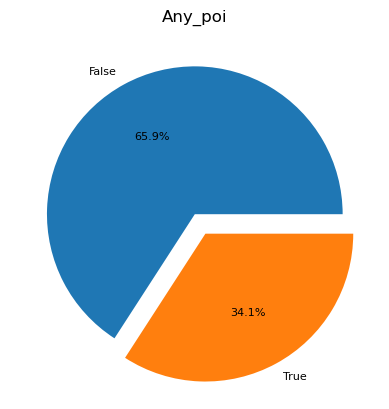

In [530]:
## Pie plot of Any_poi variable

labels = ['False', 'True']
    
plt.pie(df['Any_poi'].value_counts(), labels = labels,autopct = '%1.1f%%', labeldistance=1.1,textprops={'fontsize': 8}, explode=[0, 0.15])
plt.title("Any_poi", fontsize = 12, color='black')
plt.show()

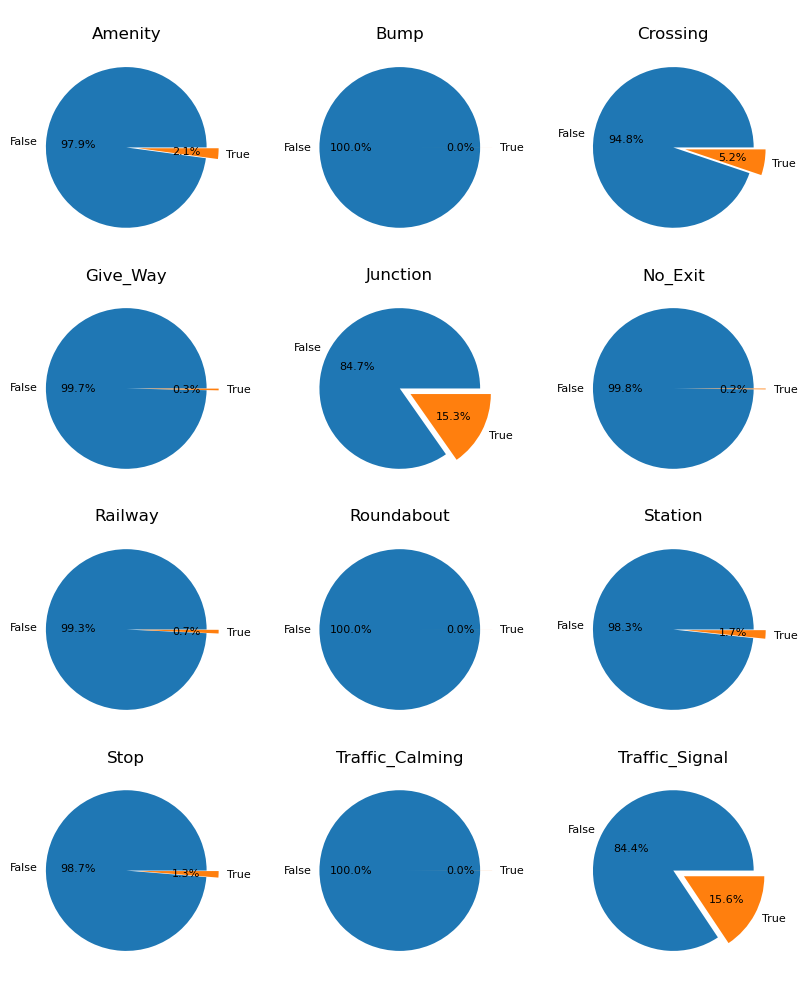

In [531]:
## Pie plot of individual poi variables

fig, ((p1, p2, p3), (p4, p5, p6), (p7, p8, p9), (p10, p11, p12)) = plt.subplots(nrows=4, ncols=3, figsize = (10,12))

count = 0

for i in [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12]:
    
    size = list(df[poi[count]].value_counts())
    if len(size) != 2:
      size.append(0)
    
    labels = ['False', 'True']
    
    i.pie(size, labels = labels,autopct = '%1.1f%%', labeldistance=1.1,textprops={'fontsize': 8}, explode=[0, 0.15])

    title = '\n{}'.format(poi[count])

    i.set_title(title, fontsize = 12, color='black')
    
    count += 1

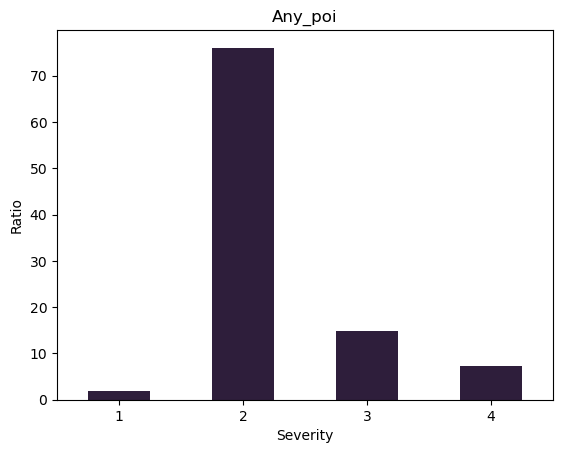

In [532]:
## Plot poi: Any_poi (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.Any_poi == True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'Any_poi', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

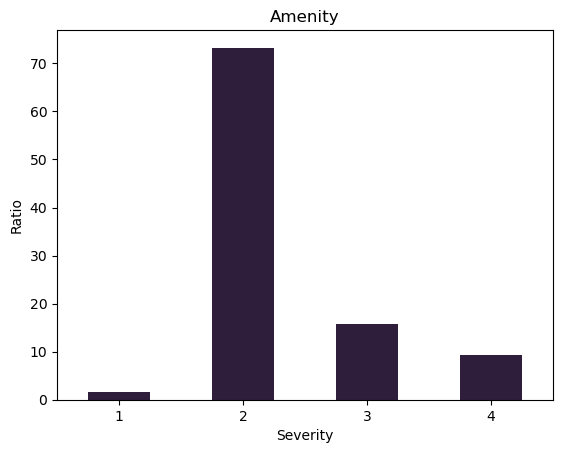

In [533]:
## Plot poi: Amenity (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.Amenity == True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'Amenity', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

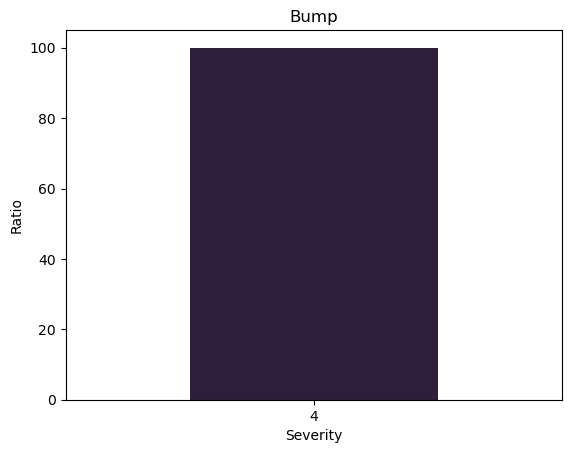

In [534]:
## Plot poi: Bump (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.Bump== True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'Bump', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

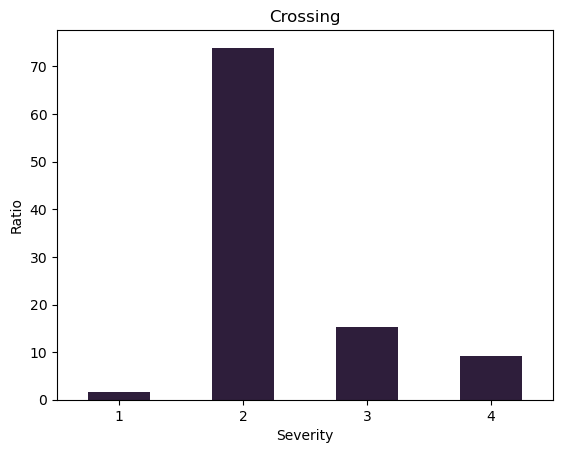

In [535]:
## Plot poi: Crossing (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.Crossing == True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'Crossing', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

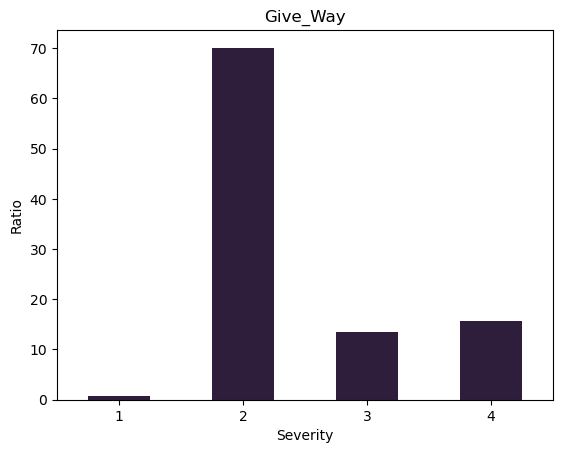

In [536]:
## Plot poi: Give_Way (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.Give_Way == True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'Give_Way', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

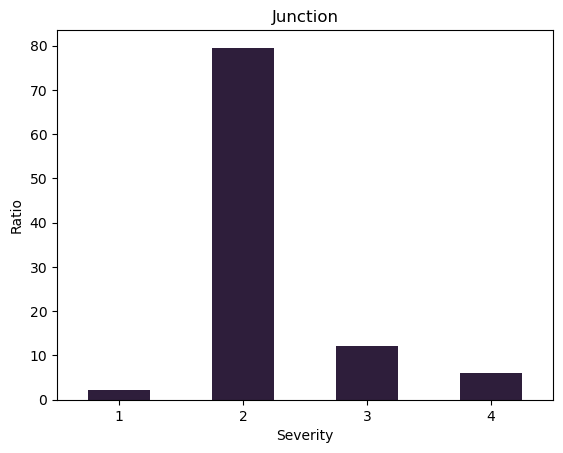

In [537]:
## Plot poi: Junction (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.Junction == True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'Junction', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

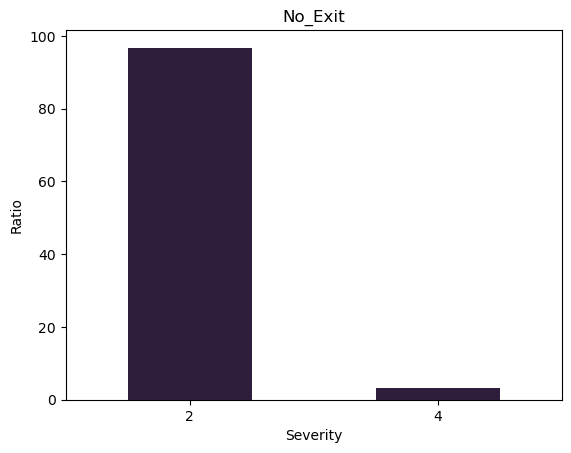

In [538]:
## Plot poi: No_Exit (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.No_Exit == True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'No_Exit', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

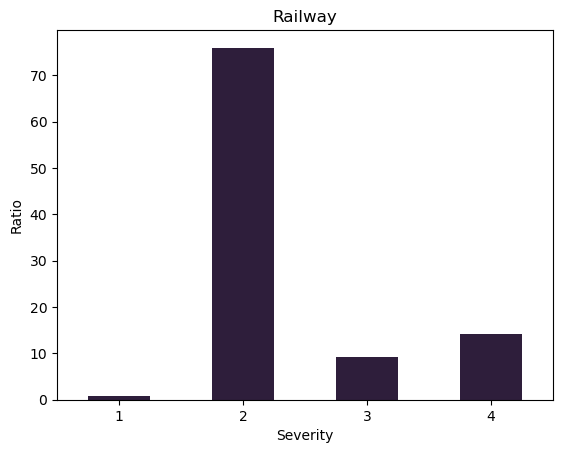

In [539]:
## Plot poi: Railway (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.Railway == True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'Railway', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

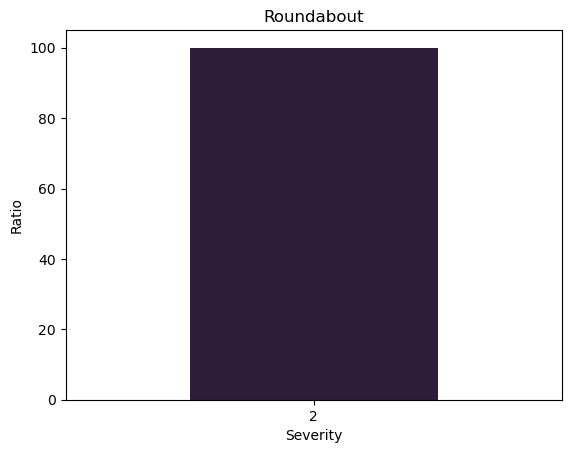

In [540]:
## Plot poi: Roundabout (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.Roundabout == True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'Roundabout', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

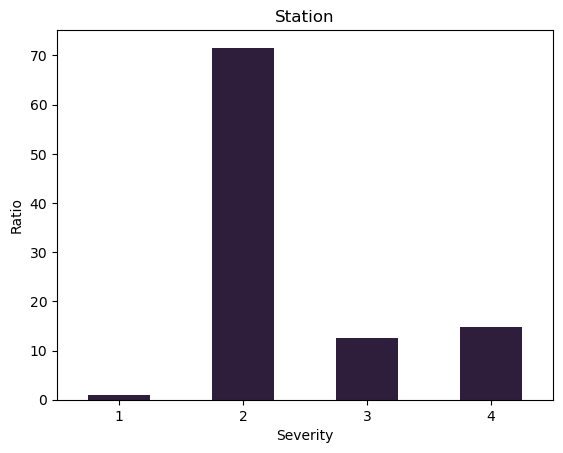

In [541]:
## Plot poi: Station (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.Station == True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'Station', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

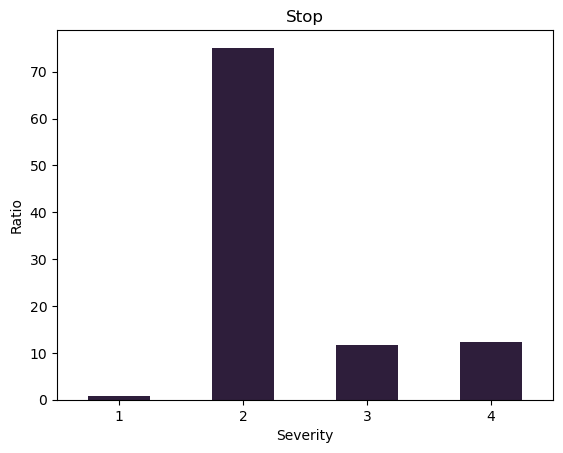

In [542]:
## Plot poi: Stop (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.Stop == True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'Stop', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

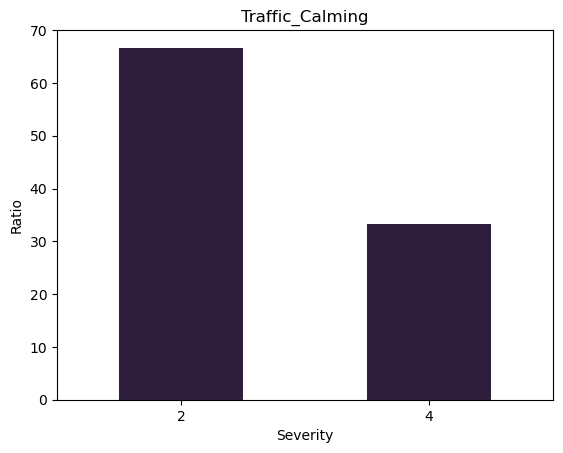

In [543]:
## Plot poi: Traffic_Calming (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.Traffic_Calming == True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'Traffic_Calming', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

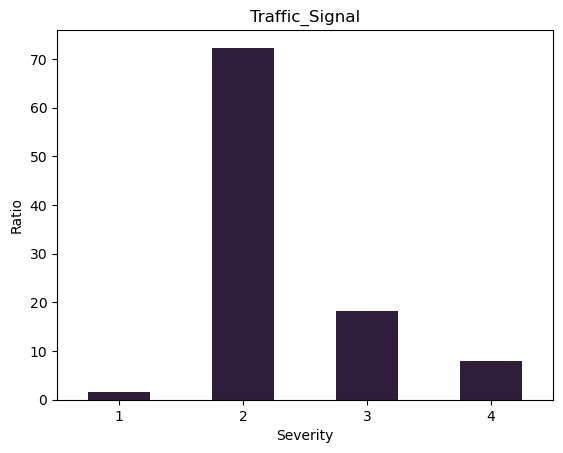

In [544]:
# Plot poi: Traffic_Signal (Summarise Severity category)
severity_prop = pd.DataFrame()
severity_prop['count'] = df[(df.Traffic_Signal == True)]['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100
severity_prop

# Plot percentage of severity by category
severity_prop['percent'].plot(kind='bar', title= 'Traffic_Signal', xlabel='Severity', ylabel='Ratio', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
plt.show()

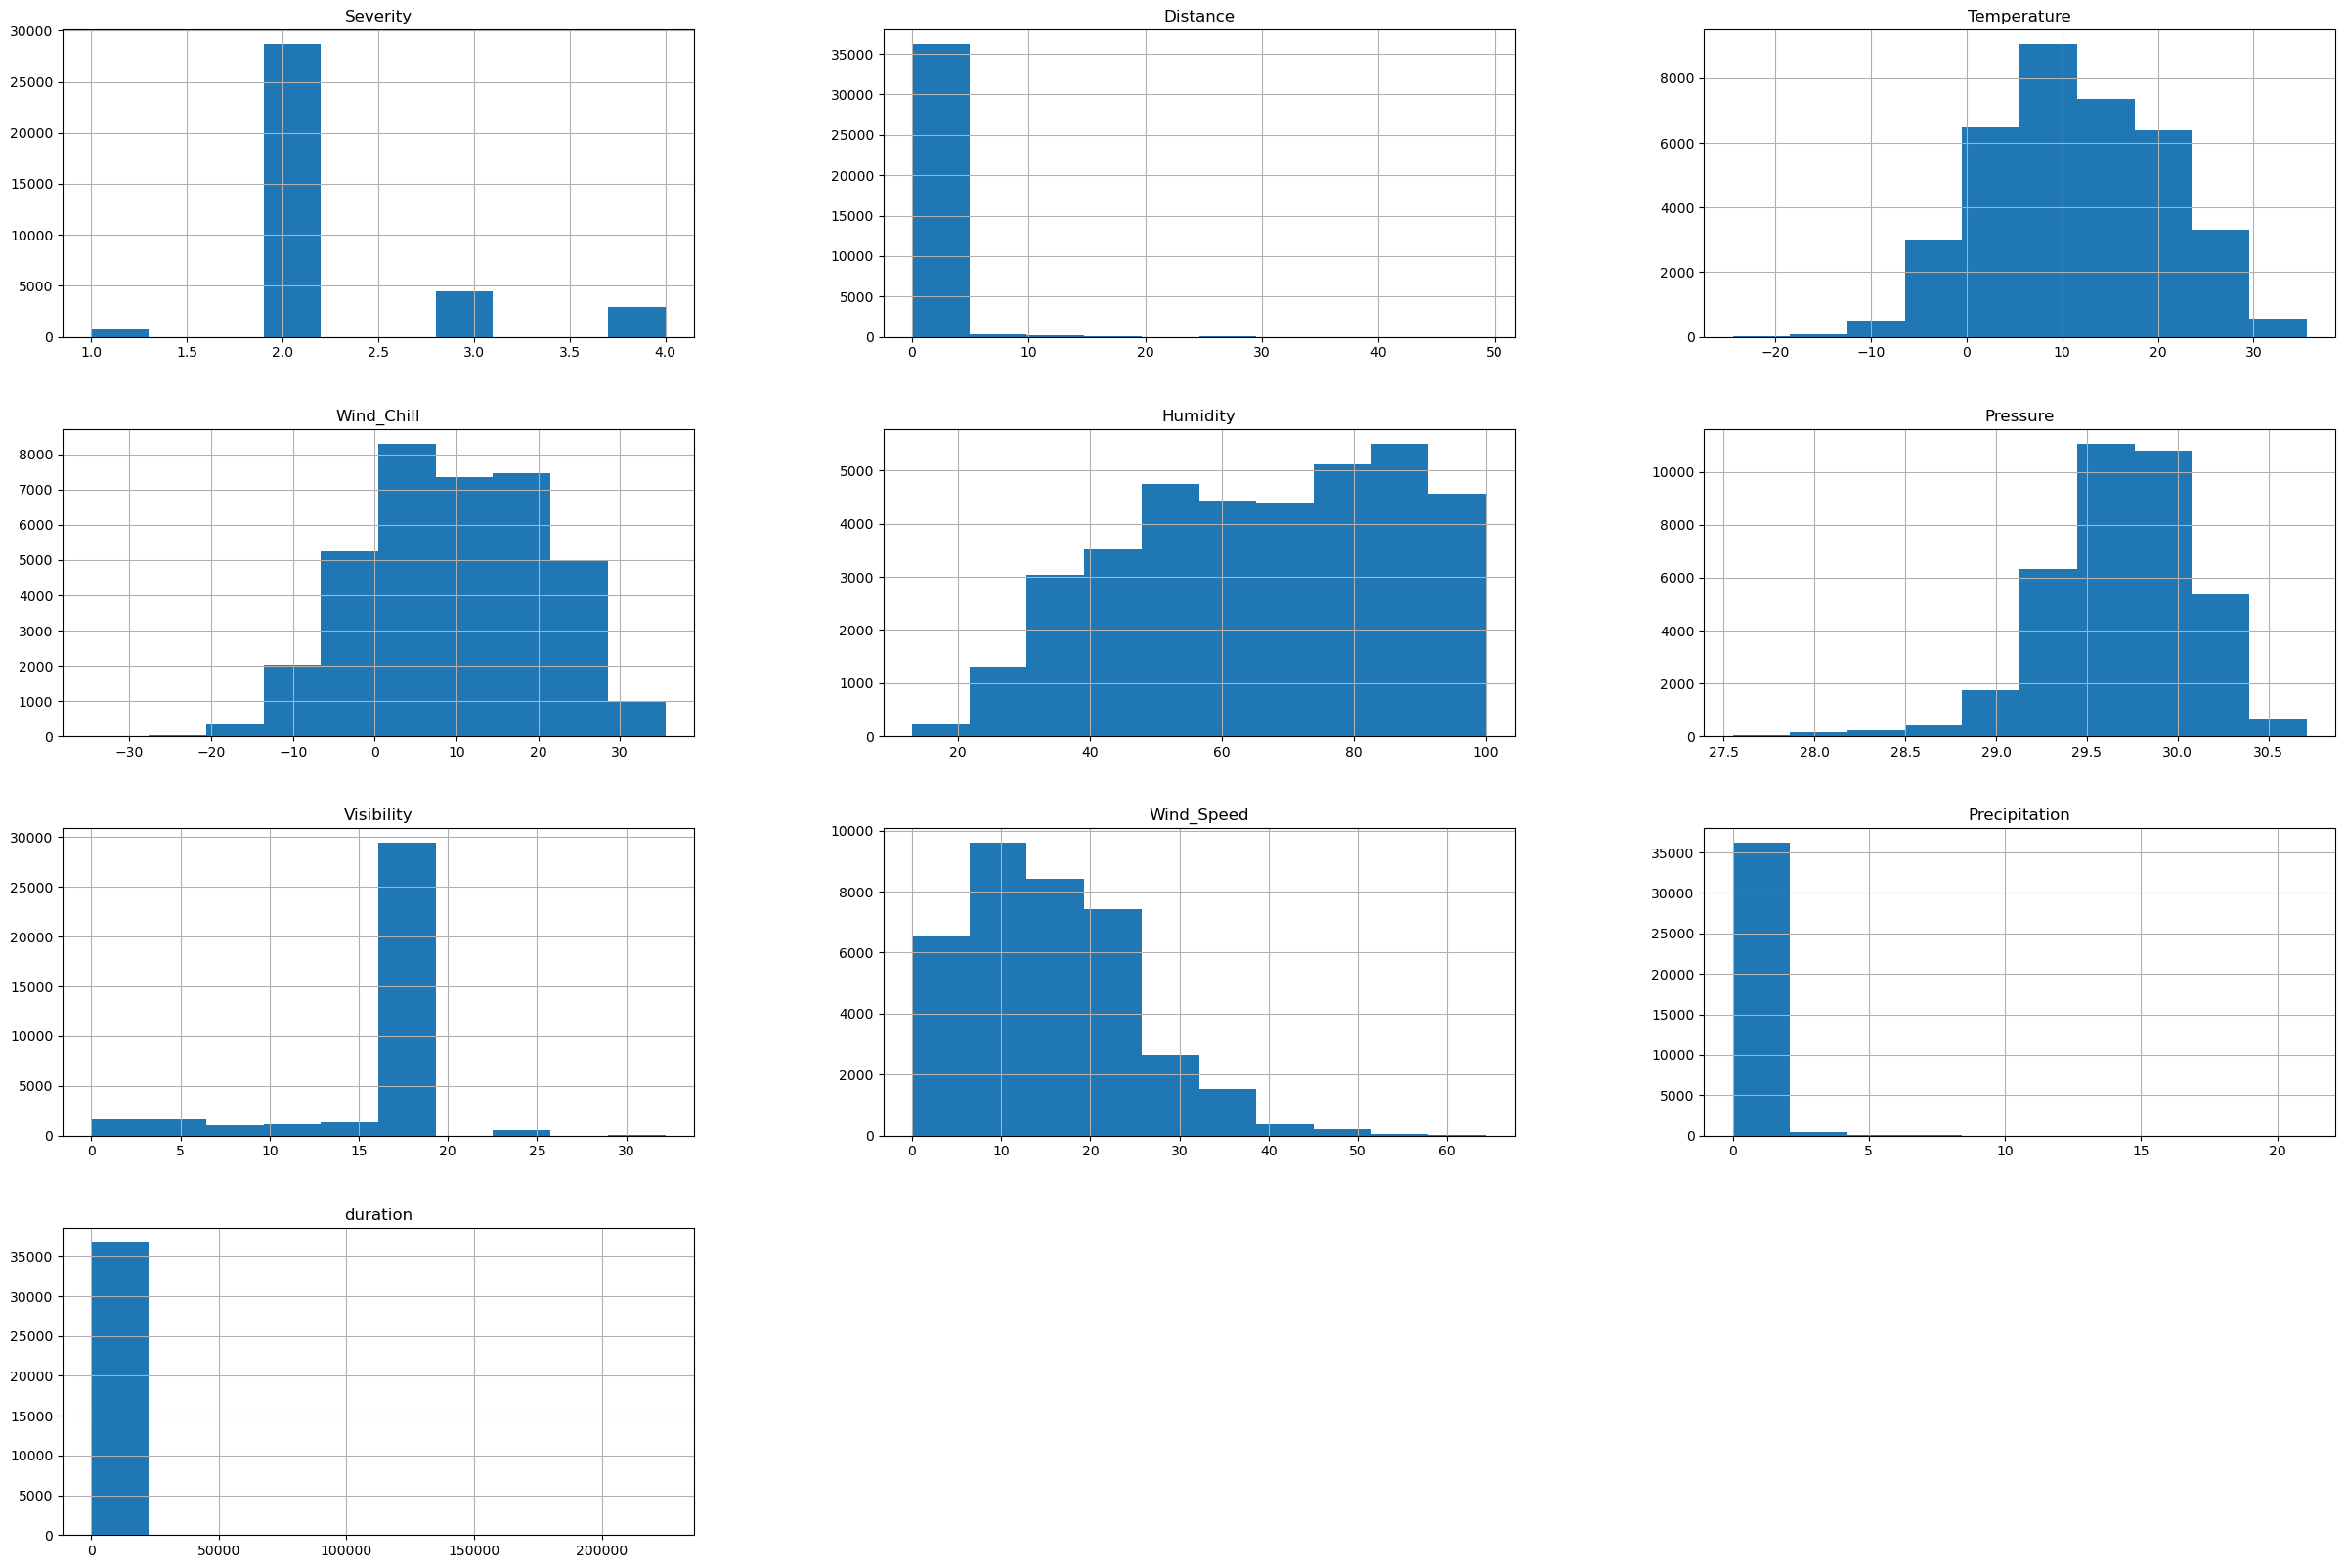

In [545]:
# Plot distribution of numeric data
numeric_cols = ['Severity', 'Distance', 'Temperature', 'Wind_Chill', 'Humidity', 'Pressure', 'Visibility',
       'Wind_Speed', 'Precipitation', 'duration']
df[numeric_cols].hist(figsize=(30,20));

In [546]:
# Summarise weather data
pd.options.display.float_format = '{:,.2f}'.format # display 2 decimal points
num_weather = ['Temperature', 'Wind_Chill', 'Humidity', 'Pressure','Visibility','Wind_Speed','Precipitation'] # weather columns containing numerical variables
df_weather_stats = df[num_weather].describe().T
df_weather_stats = pd.concat([df_weather_stats, df[num_weather].skew()], axis=1).rename(columns={0:'Skewness'})
df_weather_stats = pd.concat([df_weather_stats, df[num_weather].kurt()], axis=1).rename(columns={0:'Kurtosis'})
df_weather_stats['Trimmed Mean'] = stats.trim_mean(df[num_weather], 0.1)
display(df_weather_stats)



,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis,Trimmed Mean
Temperature,"36,779.00",11.41,9.18,-24.44,4.44,11.11,18.33,35.56,0.03,-0.54,11.36
Wind_Chill,"36,779.00",10.00,10.71,-34.67,1.67,11.11,18.33,35.56,-0.15,-0.68,10.17
Humidity,"36,779.00",66.18,20.53,13.00,50.00,68.00,84.00,100.00,-0.22,-1.00,66.87
Pressure,"36,779.00",29.69,0.39,27.55,29.45,29.72,29.97,30.71,-0.73,1.51,29.71
Visibility,"36,779.00",14.52,4.32,0.00,16.09,16.09,16.09,32.19,-1.85,3.67,15.59
Wind_Speed,"36,779.00",14.60,9.43,0.00,8.05,12.87,20.92,64.37,0.68,0.74,14.08
Precipitation,"36,779.00",0.13,0.70,0.00,0.00,0.00,0.00,21.08,10.24,149.76,0.00


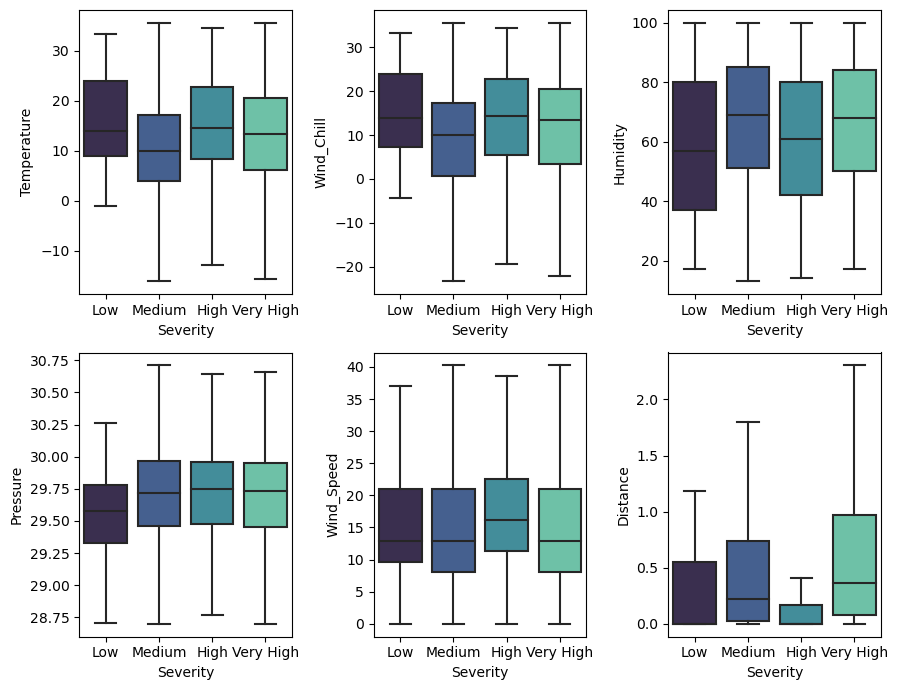

In [547]:
# Boxplot each variable
fig, ax = plt.subplots(2, 3)
fig.set_figheight(7)
fig.set_figwidth(9)
sns.boxplot(ax = ax[0, 0], x='Severity',y='Temperature', data=df, palette='mako', showfliers=False)
sns.boxplot(ax=ax[0, 1], x='Severity',y='Wind_Chill', data=df, palette='mako', showfliers=False)
sns.boxplot(ax= ax[0, 2], x='Severity',y='Humidity', data=df, palette='mako', showfliers=False)
sns.boxplot(ax = ax[1, 0], x='Severity',y='Pressure', data=df, palette='mako', showfliers=False)
sns.boxplot(ax = ax[1, 1], x='Severity',y='Wind_Speed', data=df, palette='mako', showfliers=False)
sns.boxplot(ax = ax[1, 2], x='Severity',y='Distance', data=df, palette='mako', showfliers=False)
plt.setp(ax, xticks=[0, 1, 2, 3], xticklabels=['Low', 'Medium', 'High', 'Very High'])
fig.tight_layout()

Explore the dataset

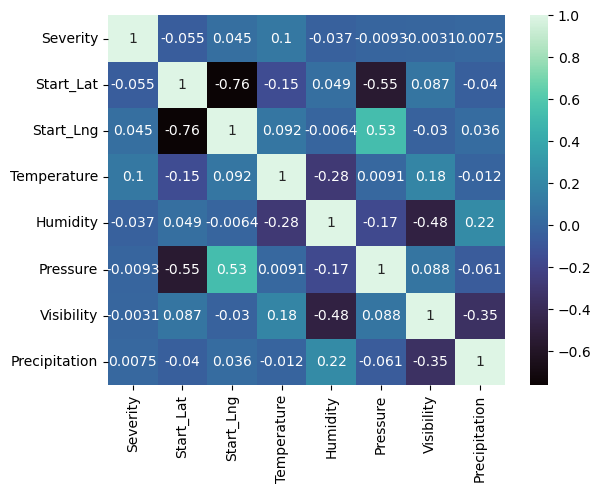

In [548]:
# Find correlations for weather features
sns.heatmap(df[['Severity','Start_Lat','Start_Lng','Temperature', 'Humidity', 'Pressure', 'Visibility','Precipitation','Weather_Condition']].corr(), cmap='mako', annot=True)
plt.show()

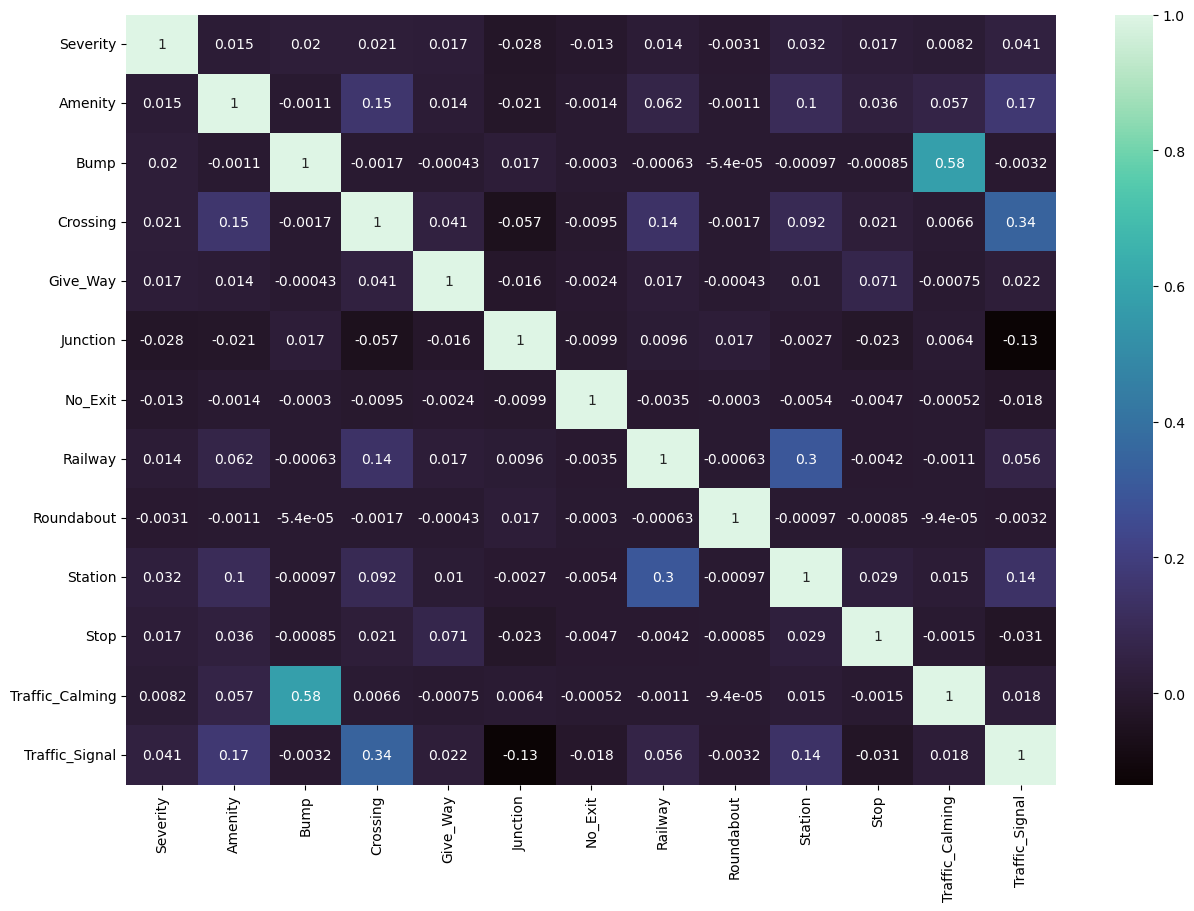

In [549]:
## Find correlations for poi features 
plt.figure(figsize=(15,10))
sns.heatmap(df[['Severity','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']].corr(), cmap='mako', annot=True)
plt.show()

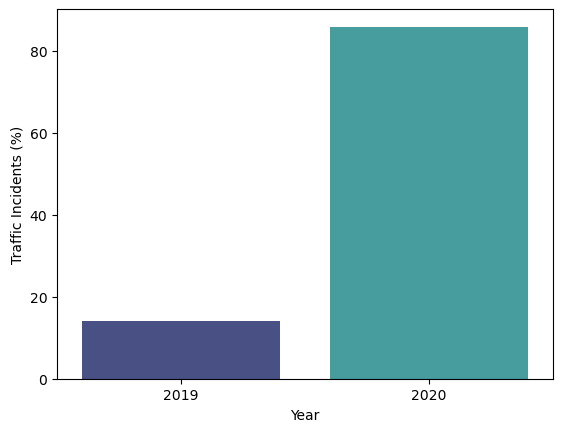

In [550]:
# Accident Severity Counts by Year
ax = sns.barplot(x='year', y='year', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette = 'mako')
ax.set(title='', xlabel="Year", ylabel="Traffic Incidents (%)")
plt.show()

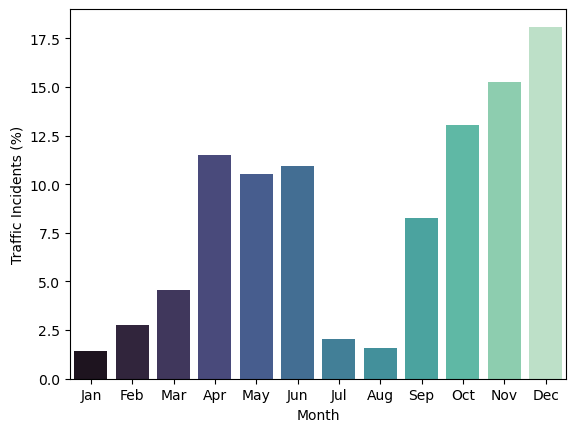

In [551]:
# Accident Severity Counts by Month
ax = sns.barplot(x='month', y='month', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette = 'mako')
ax.set(title='', xlabel="Month", ylabel="Traffic Incidents (%)")
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

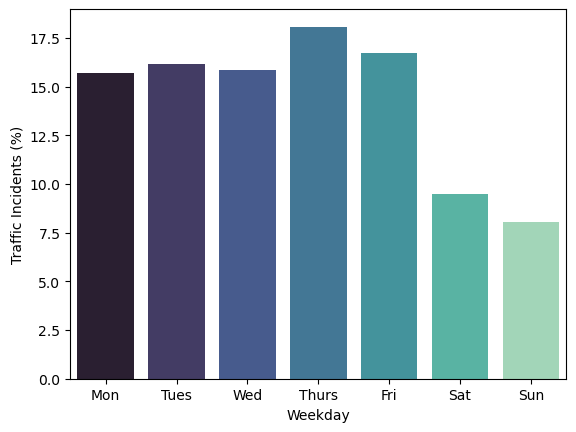

In [552]:
# Accident Severity Counts by Day of Week
ax = sns.barplot(x='weekday', y='weekday', data=df, estimator=lambda x: len(x) / len(df) * 100, palette = 'mako')
ax.set(title='', xlabel = "Weekday", ylabel="Traffic Incidents (%)")
ax.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs','Fri','Sat','Sun'])
plt.show()

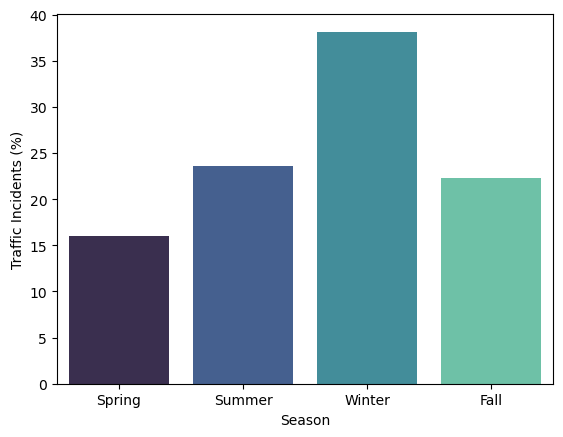

In [553]:
# Accident Severity Counts by Season
ax = sns.barplot(x='season', y='Severity', order = ['spring','summer','fall','winter'], estimator=lambda x: len(x) / len(df) * 100, data=df,  palette = 'mako')
ax.set(title='', xlabel = "Season", ylabel="Traffic Incidents (%)")
ax.set_xticklabels(['Spring','Summer', 'Winter', 'Fall'])
plt.show()

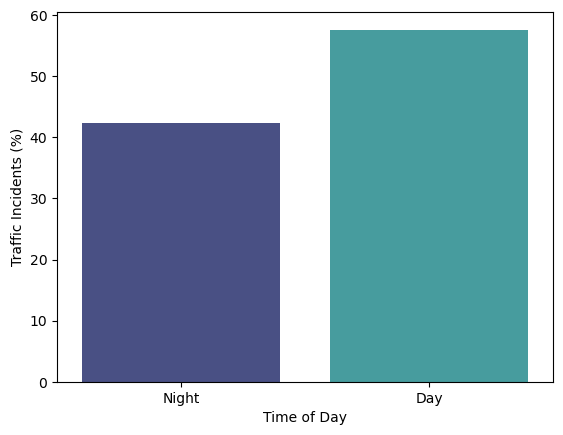

In [554]:
# Accident Severity Counts by Day/Night
ax = sns.barplot(x='Sunrise_Sunset', y='Severity', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette = 'mako')
ax.set(title='', xlabel="Time of Day", ylabel="Traffic Incidents (%)")
plt.show()

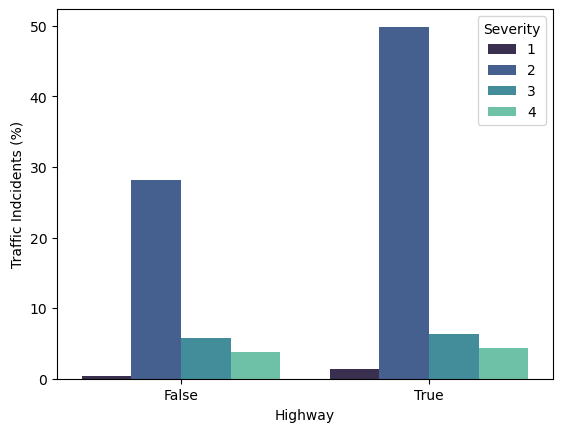

In [555]:
# Accident Severity Counts by Road Type
ax = sns.barplot(x='Highway', y='Highway', hue='Severity', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette = 'mako')
ax.set(title='', xlabel="Highway", ylabel="Traffic Indcidents (%)")
plt.show()

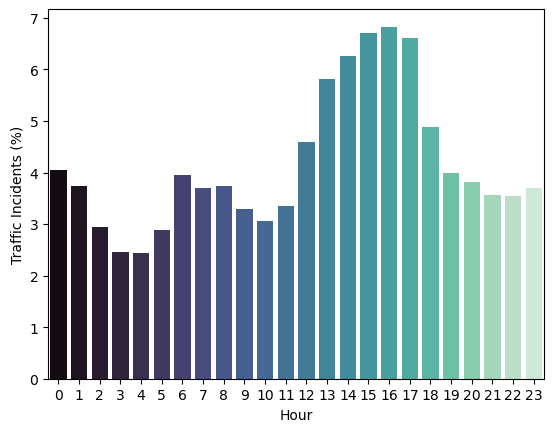

In [556]:
# Number of accidents per hour
ax = sns.barplot(x=df['Start_Time'].dt.hour, y='Severity', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette = 'mako')
ax.set(title='', xlabel="Hour", ylabel="Traffic Incidents (%)")
plt.show()

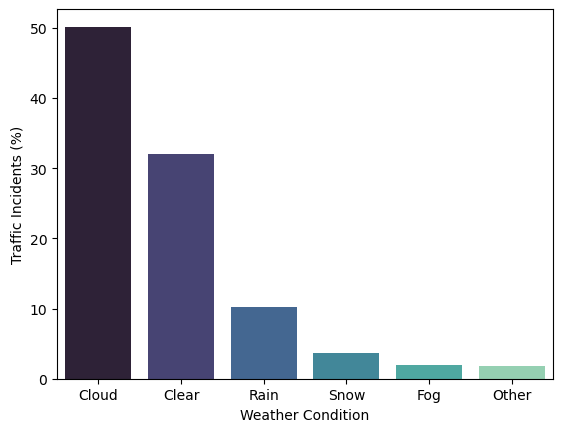

In [557]:
# Accident Severity Counts by Weather Conditions
plot_order = df.groupby('Weather_Condition')['Weather_Condition'].count().sort_values(ascending=False).index.values
ax = sns.barplot(x='Weather_Condition', y='Severity', data=df, estimator=lambda x: len(x) / len(df) * 100 ,order=plot_order, palette = 'mako')
ax.set(title='', xlabel="Weather Condition", ylabel="Traffic Incidents (%)")
plt.show()

In [558]:
plot_order

array(['Cloud', 'Clear', 'Rain', 'Snow', 'Fog', 'Other'], dtype=object)

Classification Models to Predict Severity

In [559]:
# Prepare training and test data
exclude = ['ID', 'End_Lat','End_Lng','Start_Time', 'End_Time','Description', 'Street', 'Side','City','County','Zipcode','Weather_Timestamp', 'Wind_Direction','Severity', 'Weather_Condition', 'Sunrise_Sunset','severitycat','season','duration', 'Traffic_Calming_ex_Bump', 'total_TC_B', 'TC_and_B']
df_feat = df.copy().drop(columns = exclude)
df_target = df.Severity.copy()

# Normalise the data
cols_to_norm = ['Start_Lat', 'Start_Lng', 'Distance','Temperature', 'Wind_Chill', 'Humidity', 'Pressure', 'Visibility',
       'Wind_Speed', 'Precipitation', 'weekday', 'month','year']
df_feat[cols_to_norm] = df_feat[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size = 0.3, random_state=1)

# Output size of test and training sets
print("Training set size is: ", len(X_train))
print("Test set size is: ", len(X_test))

Training set size is:  25745
Test set size is:  11034


In [560]:
# Balance training dataset
smo_tek = SMOTETomek(random_state=1)
X_train, y_train = smo_tek.fit_resample(X_train, y_train)

# Create df to store model performance 
results = pd.DataFrame(columns = ['Model','Precision', 'Recall','F1-Score','Accuracy'])

# Output info after balancing
print("Balanced training set size is: ", len(X_train))

df = y_train.value_counts().rename_axis('Severity').reset_index(name='Count')
display(df.sort_values('Severity').style.hide(axis='index'))

Balanced training set size is:  79754


Severity,Count
1,20008
2,19892
3,19904
4,19950


Supervised Learning Algorithms

In [561]:
# K-Nearest Neghbours
parameters = {'n_neighbors': np.arange(1, 20)}

# Find the best value of n parameters for accuracy
grid = RandomizedSearchCV(KNeighborsClassifier(), parameters, cv = 5, random_state=1, scoring='f1_weighted')
grid.fit(X_train, y_train)

# Return parameters of model with highest accuracy
optimal_model = grid.best_estimator_
print('Best parameters are: ')
print( grid.best_params_)

grid_predictions = grid.predict(X_test) # Perform prediction on test data
results.loc[len(results)] = scores('K-Nearest N', y_test, grid_predictions) # Store metrics to results df

Best parameters are: 
{'n_neighbors': 2}


Unsupervised Learning algorithms

In [562]:
# # Random Forest
parameters = {'n_estimators': [500, 1000, 1500, 2000],
               'max_depth': [20, 40, 60, 80, 100],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

grid = RandomizedSearchCV(RandomForestClassifier(), parameters, cv = 2, random_state=1, scoring='f1_weighted', verbose = 0)
grid.fit(X_train, y_train)

# Return parameters of model with highest accuracy
optimal_model = grid.best_estimator_
print('Best parameters are: ')
print( grid.best_params_)

grid_predictions = grid.predict(X_test) # Perform prediction on test data

results.loc[len(results)] = scores('Random Forest', y_test, grid_predictions) # Store metrics to results df

# Plot important features
feature_names = df_feat.columns
importances = grid.best_estimator_.feature_importances_

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)

fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax)
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

KeyboardInterrupt: 

In [ ]:
# mod = RandomForestClassifier(random_state=1, n_estimators=1500, min_samples_split=5, min_samples_leaf=1, max_depth=60, bootstrap=False).fit(X_train, y_train) # train model
# predicted_class = mod.predict(X_test) # perform predictionf

# # Plot important features
# feature_names = df_feat.columns
# importances = mod.feature_importances_

# gbs_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# fig, ax = plt.subplots()
# gbs_importances.plot.barh(ax=ax)
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

KeyboardInterrupt: 

In [563]:
# GradientBoosting

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

parameters = {'learning_rate' : [0.10,0.20,0.30],
               'max_depth': [20, 40, 60, 80, 100],
               'min_child_weight': [2, 5, 10],
               'gamma': [ 0.0, 0.2 , 0.4 ],
                'colsample_bytree' : [ 0.3, 0.5]}

# grid = RandomizedSearchCV(XGBClassifier(tree_method='gpu_hist'), parameters, cv = 5, random_state=1, scoring='f1_weighted', verbose = 0) # Use GPU
grid = RandomizedSearchCV(XGBClassifier(), parameters, cv = 5, random_state=1, scoring='f1_weighted', verbose = 0)
grid.fit(X_train, y_train)

# Return parameters of model with highest accuracy
optimal_model = grid.best_estimator_
print('Best parameters are: ')
print( grid.best_params_)

grid_predictions = grid.predict(X_test) # Perform prediction on test data

results.loc[len(results)] = scores('Gradient Boosting', y_test, grid_predictions) # Store metrics to results df

# Plot important features
feature_names = df_feat.columns
importances = grid.best_estimator_.feature_importances_

gbs_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)

fig, ax = plt.subplots()
gbs_importances.plot.barh(ax=ax)
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1250, in fit
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 188, in train
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 81, in _train_internal
    Validation metrics will help us track the performance of the model.
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 1680, in update
    ptr = (ctypes.c_char * len(buf)).from_buffer(buf)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 218, in _check_call
    XGBoost Library ({libname}) could not be loaded.
xgboost.core.XGBoostError: [22:20:49] c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\common\common.h:157: XGBoost version not compiled with GPU support.

--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1250, in fit
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 188, in train
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 81, in _train_internal
    Validation metrics will help us track the performance of the model.
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 1680, in update
    ptr = (ctypes.c_char * len(buf)).from_buffer(buf)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 218, in _check_call
    XGBoost Library ({libname}) could not be loaded.
xgboost.core.XGBoostError: [22:20:50] c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\common\common.h:157: XGBoost version not compiled with GPU support.

--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1250, in fit
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 188, in train
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 81, in _train_internal
    Validation metrics will help us track the performance of the model.
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 1680, in update
    ptr = (ctypes.c_char * len(buf)).from_buffer(buf)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 218, in _check_call
    XGBoost Library ({libname}) could not be loaded.
xgboost.core.XGBoostError: [22:20:51] c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\common\common.h:157: XGBoost version not compiled with GPU support.

--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1250, in fit
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 188, in train
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 81, in _train_internal
    Validation metrics will help us track the performance of the model.
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 1680, in update
    ptr = (ctypes.c_char * len(buf)).from_buffer(buf)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 218, in _check_call
    XGBoost Library ({libname}) could not be loaded.
xgboost.core.XGBoostError: [22:20:52] c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\common\common.h:157: XGBoost version not compiled with GPU support.

--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1250, in fit
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 188, in train
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 81, in _train_internal
    Validation metrics will help us track the performance of the model.
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 1680, in update
    ptr = (ctypes.c_char * len(buf)).from_buffer(buf)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 218, in _check_call
    XGBoost Library ({libname}) could not be loaded.
xgboost.core.XGBoostError: [22:20:53] c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\common\common.h:157: XGBoost version not compiled with GPU support.

--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1250, in fit
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 188, in train
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py", line 81, in _train_internal
    Validation metrics will help us track the performance of the model.
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 1680, in update
    ptr = (ctypes.c_char * len(buf)).from_buffer(buf)
  File "C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py", line 218, in _check_call
    XGBoost Library ({libname}) could not be loaded.
xgboost.core.XGBoostError: [22:20:54] c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\common\common.h:157: XGBoost version not compiled with GPU support.


Results

In [ ]:
# mod = XGBClassifier(random_state=1, min_child_weight=2, max_depth=100, learning_rate=0.1, gamma=0.0, colsample_bytree=0.5).fit(X_train, y_train) # train model
# predicted_class = mod.predict(X_test) # perform predictionf

# # Plot important features
# feature_names = df_feat.columns
# importances = mod.feature_importances_

# gbs_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# fig, ax = plt.subplots()
# gbs_importances.plot.barh(ax=ax)
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

KeyboardInterrupt: 

In [ ]:
# Output results of models
display(results.round(4).style.hide(axis = 'index'))

Model,Precision,Recall,F1-Score,Accuracy
K-Nearest Neighbours,0.854800,0.842100,0.847400,0.842100
Random Forest,0.883300,0.876100,0.879100,0.876100
Gradient Boosting,0.880700,0.885000,0.882200,0.885000
